<a href="https://colab.research.google.com/github/sofaemha/archive/blob/main/2025-9/cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import subprocess

In [13]:
github_dataset = 'https://github.com/sofaemha/computer-vision.git'

In [14]:
def shell(command):
  print(subprocess.run(command, capture_output=True, text=True).stdout)

def remove_folder(folder_name):
  shell(['rm', '-rf', folder_name])

def git_clone():
  shell(['git', 'clone', github_dataset, 'dataset'])

def show_folder():
  shell(['ls', '-la'])

In [17]:
show_folder()

total 20
drwxr-xr-x 1 root root 4096 Oct  5 15:10 .
drwxr-xr-x 1 root root 4096 Oct  5 14:11 ..
drwxr-xr-x 4 root root 4096 Oct  2 13:36 .config
drwxr-xr-x 5 root root 4096 Oct  5 15:10 dataset



In [10]:
# remove_folder('sample_data')
# remove_folder('dataset')

In [16]:
git_clone()

---

In [18]:
!pip install tf_explain

In [19]:
# Common
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [20]:
# Data
from tqdm import tqdm
from glob import glob
from PIL import Image
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array

In [21]:
# Data Visulization
import matplotlib.pyplot as plt

In [22]:
# Model Layers
from keras.models import Model
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, ReLU
from keras.models import Sequential

In [23]:
# Backbone
from tensorflow.keras.applications import ResNet50

In [24]:
# Model Architecture Visualization
from tensorflow.keras.utils import plot_model

In [25]:
# Optimizer
from tensorflow.keras.optimizers import Adam

In [26]:
# Callbacks
from keras.callbacks import ModelCheckpoint, Callback

In [27]:
# Model Layer Visualization
from tf_explain.core.grad_cam import GradCAM

In [31]:
# Specify paths
root_path = 'dataset/'
image_path = 'dataset/all_data/images/'
mask_path = 'dataset/all_data/masks/'

In [29]:
def load_image(path, mask=False):
    img = Image.open(path)
    img = img.resize((256, 256))  # Resize the image to (256, 256)
    img = np.array(img)
    if mask:
        img = np.expand_dims(img, axis=-1)  # Add one more dimension for masks
    img = img / 255.0  # Normalize the image data
    return img

In [37]:
def load_data(root_path):
    # Load the Image and Mask paths
    image_paths = sorted(glob(root_path + "*.jpg"))
    mask_paths = [path.replace("images", "masks").replace("jpg", "png") for path in image_paths]

    # Create space for loading the images and masks
    images = np.empty(shape=(len(image_paths), 256, 256, 3), dtype=np.float32)
    masks = np.empty(shape=(len(image_paths), 256, 256, 1), dtype=np.float32)

    # Load the images and masks
    for i, (img_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), desc="Loading"):
        # Load the image
        image = load_image(path=img_path, mask=False)
        # Load the respective mask
        mask = load_image(path=mask_path, mask=True)
        # Put this into the space
        images[i] = image
        masks[i] = mask

    return images, masks

In [32]:
# Load data
all_images, all_masks = load_data(image_path)

dataset/all_data/images/


Loading: 2940it [01:02, 47.37it/s] 


In [33]:
# Check if images and masks are loaded properly
print("Total images:", len(all_images))
print("Total masks:", len(all_masks))

Total images: 2940
Total masks: 2940


In [34]:
# Split data into training and testing sets
data_len = len(all_images)
train_images, train_masks = all_images[:int(data_len * 0.8)], all_masks[:int(data_len * 0.8)]
test_images, test_masks = all_images[int(data_len * 0.8):], all_masks[int(data_len * 0.8):]

In [35]:
# Check the length of training and testing sets
print("Training images:", len(train_images))
print("Training masks:", len(train_masks))
print("Testing images:", len(test_images))
print("Testing masks:", len(test_masks))

Training images: 2352
Training masks: 2352
Testing images: 588
Testing masks: 588


In [45]:
def show_images(images, masks, n_images, SIZE=(15,8)) -> None:
    # Plot n Images
    for i in range(n_images):

        # Plotting Configuration
        plt.figure(figsize=SIZE)

        # Select a image Randomly
        id = np.random.randint(len(images))

        # Plot the Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[id])
        plt.title(f"Image (id:{id})")
        plt.axis('off')

        # Plot the Mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[id], cmap='gray')
        plt.title(f"Mask (id:{id})")
        plt.axis('off')

        # Plot the Overlapping Mask
        plt.subplot(1, 3, 3)
        plt.imshow(images[id], cmap='gray')
        plt.imshow(masks[id], cmap='gray', alpha=0.5)
        plt.title(f"Overlapping Mask (id:{id})")
        plt.axis('off')

        # Shwo a Single Frame : This is done to speed up plotting for large number images
        plt.tight_layout()
        plt.show()

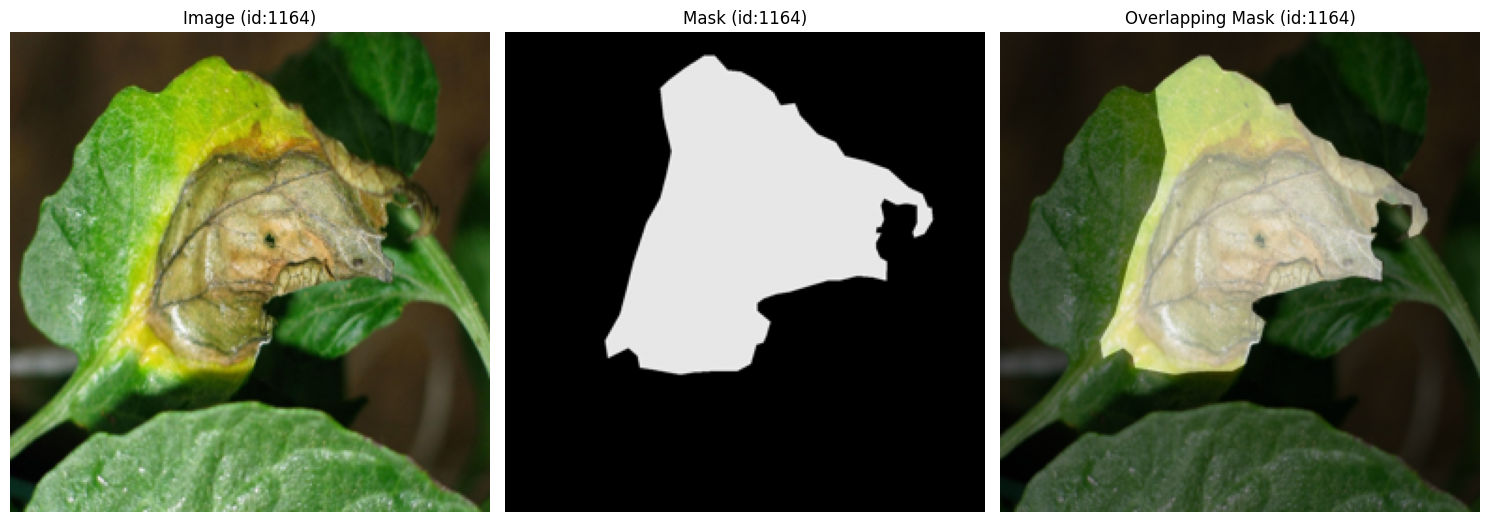

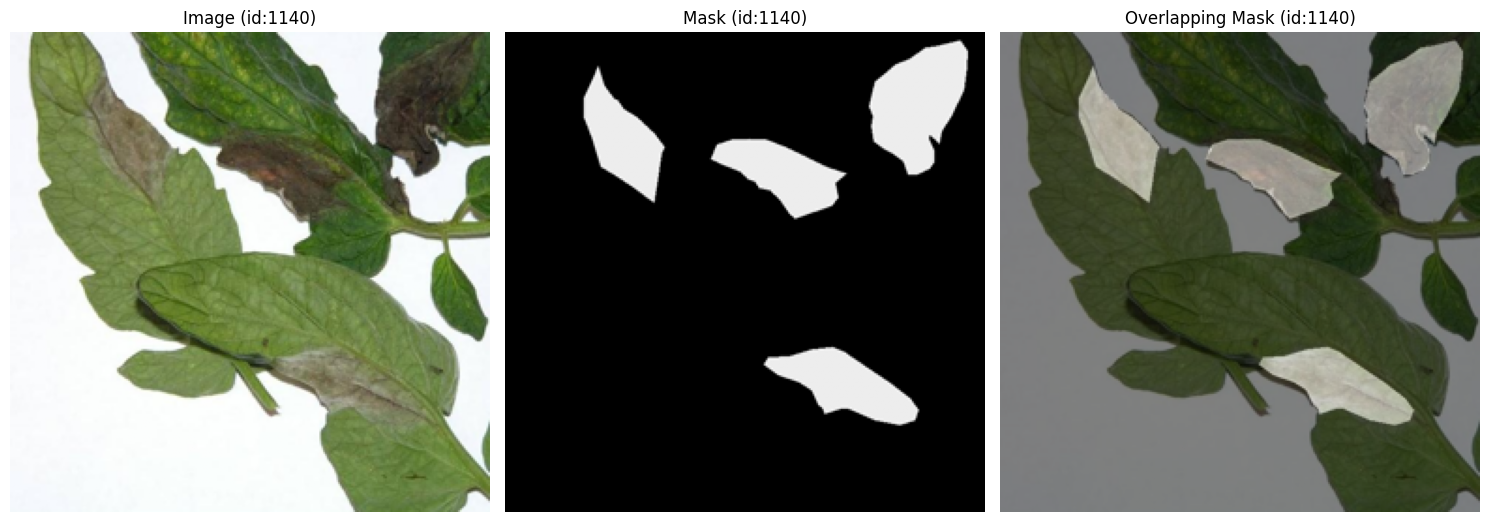

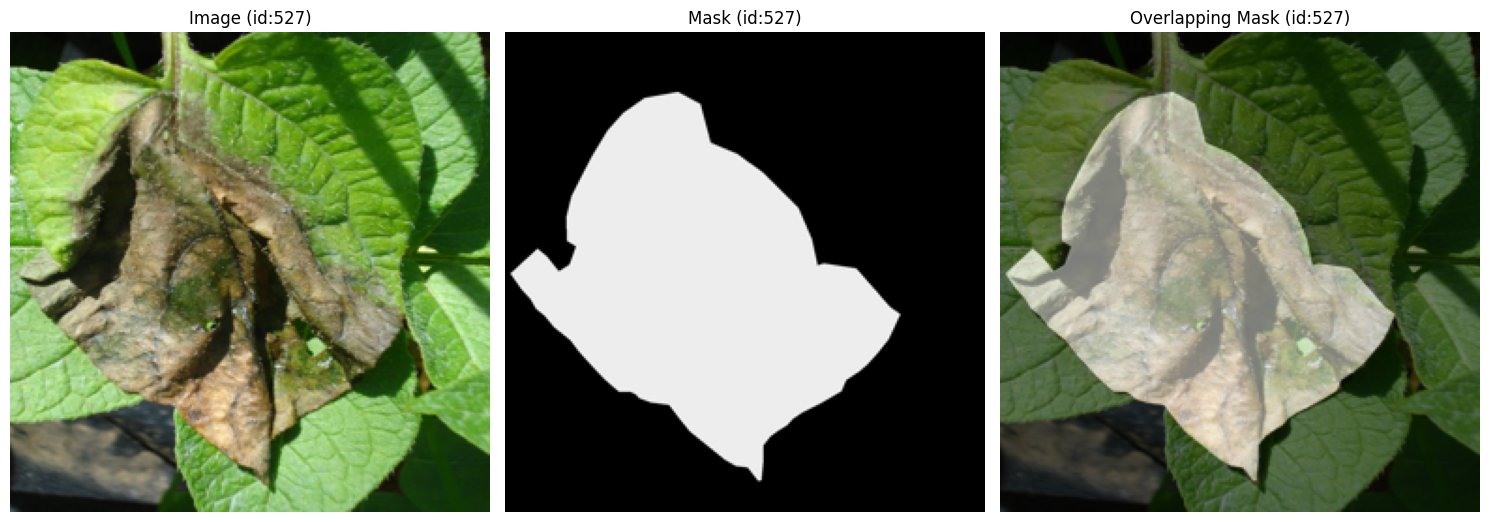

In [46]:
# Now, let's try to visualize some images from the training set
show_images(train_images, train_masks, n_images=3)

---

In [47]:
class ConvBlock(Layer):
    def __init__(self, filters:int = 256, kernel_size:int = 3, dilation_rate:int = 1, **kwargs) -> None:
        super(ConvBlock, self).__init__(**kwargs)

        # Define Parameters
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate

        # Define the model
        self.net = Sequential([
            Conv2D(filters, kernel_size=kernel_size, padding='same', strides=1, dilation_rate=dilation_rate, activation=None, use_bias=False),
            BatchNormalization(),
            ReLU()
        ])

    def call(self, X):
        # Apply the layers
        return self.net(X)

    def get_config(self):
        base_config = super().get_config()

        return {
            **base_config,
            "filters":self.filters,
            "kernel_size":self.kernel_size,
            "dilation_rate":self.dilation_rate
        }

In [48]:
def AtrousSpatialPyramidPooling(X):
    # Shape
    _, H, W, C = X.shape

    # Image Pooling
    image_pool = AveragePooling2D(pool_size=(H, W), name="ASPP-ImagePool-AP")(X)
    image_pool = ConvBlock(kernel_size=1, name="ASPP-ImagePool-CB")(image_pool)
    image_pool = UpSampling2D(size=(H//image_pool.shape[1], W//image_pool.shape[1]), name="ASPP-ImagePool-US")(image_pool)

    # Astrous Layers
    conv_1  = ConvBlock(kernel_size=1, dilation_rate=1, name="ASPP-Conv1")(X)
    conv_6  = ConvBlock(kernel_size=3, dilation_rate=6, name="ASPP-Conv6")(X)
    conv_12 = ConvBlock(kernel_size=3, dilation_rate=12, name="ASPP-Conv12")(X)
    conv_18 = ConvBlock(kernel_size=3, dilation_rate=18, name="ASPP-Conv18")(X)

    # Combine All
    combined = Concatenate(name="ASPP-Concatenate")([image_pool, conv_1, conv_6, conv_12, conv_18])
    output = ConvBlock(kernel_size=1, name="ASPP-Out")(combined)

    return output

In [49]:
# Model Specifications
IMAGE_SIZE = 256
MODEL_NAME = "DeepLab-FloodArea"

In [50]:
# Input Layer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")

In [51]:
# Backbone
backbone = ResNet50(input_tensor=inputs, weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [52]:
# High Level Features
DCNN = backbone.get_layer('conv4_block6_2_relu').output
ASPP = AtrousSpatialPyramidPooling(DCNN)
ASPP = UpSampling2D(size=(
    IMAGE_SIZE//4//ASPP.shape[1], IMAGE_SIZE//4//ASPP.shape[2]
), name="ASPP-UpSample-Out")(ASPP)

In [53]:
# Low Level Features
LLF = backbone.get_layer('conv2_block3_2_relu').output
LLF = ConvBlock(filters=48, kernel_size=1, name="LLF-ConvBlock")(LLF)

In [54]:
# Combine
concat = Concatenate(axis=-1, name="Concat-LLF-HLF")([LLF, ASPP])
y = ConvBlock(name="TopConvBlock1")(concat)
y = ConvBlock(name="TopConvBlock2")(y)
y = UpSampling2D(size=(
    IMAGE_SIZE//y.shape[1], IMAGE_SIZE//y.shape[2]
), name="Feature-UpSample")(y)

In [55]:
# Output Layer
output = Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid', use_bias=False, name="OutputLayer")(y)

In [56]:
# Model
DeepLabV3 = Model(inputs, output, name=MODEL_NAME)

In [57]:
# Model Architecture
DeepLabV3.summary()

Model: "DeepLab-FloodArea"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InputLayer          │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ InputLayer[0][0]  │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 11,854,144 (45.22 MB)

 Trainable params: 11,821,408 (45.10 MB)

 Non-trainable params: 32,736 (127.88 KB)

---

In [58]:
plot_model(DeepLabV3, MODEL_NAME+".png", dpi=96, show_shapes=True)

---

In [59]:
def show_model_preds(images, masks, model, SIZE:tuple = (15,8)) -> None:
    # Collect Image and Mask
    id = np.random.randint(len(test_images))
    image, mask = images[id], masks[id]

    # Make Prediction
    pred_mask = model.predict(tf.expand_dims(image, axis=0))

    # Grad CAM
    cam = GradCAM()
    capture = cam.explain(
        validation_data=(tf.expand_dims(image, axis=0).numpy(), mask),
        model=model,
        class_index=1,
        layer_name="TopConvBlock2"
    )

    # Plot Size
    plt.figure(figsize=SIZE)

    # Plot Image
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')

    # Plot Original Mask
    plt.subplot(1,4,2)
    plt.title("Expected Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    # Plot Predicted Mask
    plt.subplot(1,4,3)
    plt.imshow(tf.squeeze(pred_mask), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Grad CAM
    plt.subplot(1,4,4)
    plt.title("Grad CAM Visualization")
    plt.imshow(tf.squeeze(capture))
    plt.axis('off')

    # Show the Final Plot
    plt.show()

In [60]:
class ShowProgress(Callback):

    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1)%10==0:
            show_model_preds(test_images, test_masks, self.model)

In [61]:
# Compile
DeepLabV3.compile(
    loss='binary_crossentropy',
    optimizer="adam"
)

In [62]:
# Callbacks
callbacks = [
    ModelCheckpoint(MODEL_NAME+".h5", save_best_only=True),
    ShowProgress()
]

In [ ]:
# Train
history = DeepLabV3.fit(
    train_images, train_masks,
    validation_data=(test_images, test_masks),
    epochs=50,
    callbacks=callbacks,
    batch_size=8,
)

Epoch 1/50
 10/294 ━━━━━━━━━━━━━━━━━━━━ 1:52:24 24s/step - loss: 0.4000